<a id="inicio"></a>
<br><br><br>
<h2><font color="#B51700" size=5>Dataset Titanic</font></h2>



<h1><font size=5>Analisis exploratorio, preprocesamiento de los datos y selección de modelos</font></h1>


---

# 1. Introducción

En este notebook se trabajará con el problema del conjunto de datos `titanic`, este es un conjunto de datos típico para aprender a trabajar con problemas de machine learning, ya que cuenta con muchas características típicas de estos problemas que iremos viendo a lo largo del notebook (por ejemplo cuenta con outliers y valores nulos). Los datos han sido extraídos de la competición de `kaggle` [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic)

El objetivo de este notebook es ser bastante completo y que pueda ser usado como guía para trabajar con este tipo de problemas. Primero se realizará un análisis exploratorio (dividido en un análisis univariado y multivariado). De este estudio se extraerán varias conclusiones que nos permitirán realizar un buen preprocesamiento de los datos. Para el preprocesamiento de los datos se utilizará el concepto de `pipeline` para evitar realizar una fuga de datos (evitar introducir información del conjunto de test en el conjunto de entrenamiento). Además, el uso de una `pipeline` nos permite crear un objeto que realizará todas las transformaciones sobre los datos de una vez, lo que reduce la probabilidad de que ocurra un error en este paso. Para crear el `pipeline` se utilizarán componentes de la librería `sklearn` y también crearemos alguno nosotros.

Finalmente, se entrenarán varios modelos utilizando una validación cruzada para seleccionar los parámetros que mejor funcionen para cada modelo, y después, se creará un `ensemble` con los modelos que mejor resultados han obtenido. El objetivo no es obtener un score demasiado alto sino saber aplicar todos estos conceptos, porque como veremos posteriormente para este conjunto de datos tan pequeño se obtendrían mejores resultados con modelos más sencillos que con ensembles. Aún así se han obtenido buenos resultados.

Empezaremos importando las librerías necesarias.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix

# 2. Carga de datos

Antes de cargar los datos y empezar con el análisis exploratorio se va a establecer una semilla para que los resultados obtenidos a lo largo de la libreta puedan ser reproducibles.

In [2]:
seed = 42

Se van a cargar los datos de entrenamiento, que serán los que se utilicen para realizar el análisis exploratorio y para el entrenamiento de los modelos.

In [3]:
filepath = 'train.csv'
index = 'PassengerId'
data = pd.read_csv(filepath, index_col=index)

Se visualizan algunos registros aleatorios para comprobar que se han cargado los datos correctamente. Mostraremos algunos al azar para evitar obtener una muestra sesgada que no represente al conjunto de datos.

In [4]:
data.sample(5, random_state=seed)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S
841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S
721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.0000,NaN,S
40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,NaN,C


# 3. Análisis exploratorio

Para comenzar con el análisis exploratorio, primero vamos a visualizar la información general del dataset.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


De la instrucción anterior podemos ver que solo contamos con 891 registros para el entrenamiento. Este es un conjunto de datos bastante pequeño.

También se obtiene la siguiente información sobre las variables del dataset:

* ***Survived***: es la variable clase. Tipo int64.
* ***Pclass***: tipo int64.
* ***Name***: tipo object.
* ***Sex***: tipo object.
* ***Age***: tipo float64. Contiene 891-714 = 177 valores nulos.
* ***SibSp***: tipo int64.
* ***Parch***: tipo int64.
* ***Ticket***: tipo object.
* ***Fare***: tipo float64.
* ***Cabin***: tipo object. Contiene 891-204 = 687 valores nulos.
* ***Embarked***: tipo object. Contiene 891-889 = 2 valores nulos.

Podemos ver el porcentaje de valores nulos que hay en el conjunto de datos.

In [6]:
missing_values=data.isnull().sum()
missing_values[missing_values>0]/len(data)*100

Age         19.865320
Cabin       77.104377
Embarked     0.224467
dtype: float64

## 3.1. Análisis univariado

Vamos a empezar obteniendo un resumen de la información de los campos numéricos.

In [7]:
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Con esta instrucción se obtiene información muy útil de todas las variables numéricas, como su valor máximo o su media.

También nos permite detectar la presencia de outliers mediante el uso de los cuartiles y el valor máximo. Por ejemplo, para la variable `Age` observamos que el 75% de los datos tiene un valor inferior a 38, y sin embargo existe un valor máximo de 80, siendo este claramente un outlier. Se ha detectado la presencia de algún outlier para las variables:
* Age
* SibSp
* Parch
* Fare

Vamos a visualizar la cantidad de outliers que presentan estas variables.

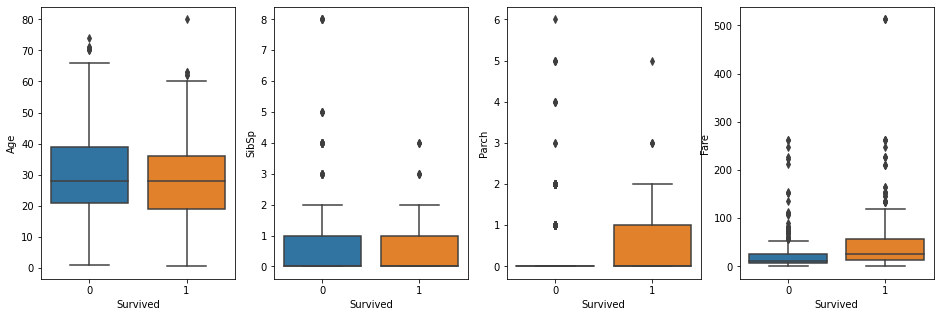

In [8]:
plt.figure(figsize=(16,5))

features_outlier = ['Age', 'SibSp', 'Parch', 'Fare']
for i,col in enumerate(features_outlier):    
    plt.subplot(1,4,i + 1)
    sns.boxplot(y=col, x='Survived', data=data)

plt.show()

Vamos a calcular cuantos outliers hay para cada una de estas variables:

In [9]:
def outlier_detect(feature, data):
    outlier_index = {}

    for col in feature:
        Q1 = np.nanpercentile(data[col], 25)
        Q3 = np.nanpercentile(data[col], 75)
        IQR = Q3 - Q1
        min_quartile = Q1 - 1.5*IQR
        max_quartile = Q3 + 1.5*IQR
        outlier_points = data[(data[col] < min_quartile) | (data[col] > max_quartile)]
        outlier_index[col] = outlier_points[col]
    return outlier_index

In [10]:
outliers = outlier_detect(features_outlier, data)

for col in outliers:
    print(col, ': ',len(outliers[col]) , ' outliers')

Age :  11  outliers
SibSp :  46  outliers
Parch :  213  outliers
Fare :  116  outliers


Vamos a estudiar cada variable de forma independiente y como se relaciona cada variable con la variable clase, pero sin tener en cuenta la relación entre varias variables (análisis univariado). 

### Survived

Primero vamos a ver la variable clase, que como observamos es una variable categórica que puede tomar los valores 0 (no sobrevivió) y 1 (sobrevivió).

<AxesSubplot:xlabel='Survived', ylabel='count'>

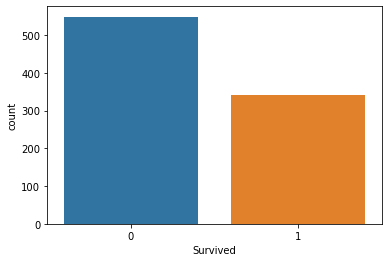

In [11]:
sns.countplot(x='Survived',data=data)

In [12]:
data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Podemos ver que tenemos un dataset desbalanceado, en el que tenemos muchos más casos con 0 que con 1. Esto puede afectar en el entrenamiento por lo que hay que tenerlo en cuenta, también a la hora de elegir la métrica de evaluación. Aunque en este caso se utilizará el `accuracy` como métrica de evaluación porque es lo que se utiliza en la competición de kaggle para medir el rendimiento de los modelos y poder compararlo con los resultados de otras personas.

Al tener un conjunto de datos desbalanceado se deberían de tener en cuenta métricas capaces de lidiar con este problema la `precisión`, el `recall` o el `balance accuracy`.

### Pclass

Vamos a analizar la variable `Pclass` que almacena la clase del ticket del pasajero. Puede tomar los valores 1, 2 o 3.

<AxesSubplot:xlabel='Pclass', ylabel='count'>

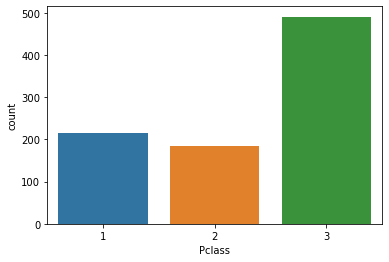

In [13]:
sns.countplot(x='Pclass',data=data)

Vemos que había muchos más pasajeros de clase 3 que de clase 1 y de clase 2.

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

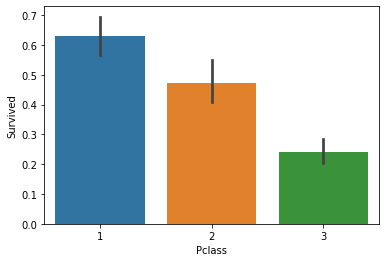

In [14]:
sns.barplot(x="Pclass", y ="Survived", data=data)

Se puede observar que hay alguna relación directa entre la variable `Pclass` y `Survived`. Observamos que sobrevivieron más pasajeros de primera clase que de segunda y, a su vez, sobrevivieron más pasajeros de segunda que de tercera clase.

### Name

La variable `Name` indica el nombre de los pasajeros, y a priori no aporta información relevante al problema, por lo que se eliminará en el preprocesamiento.

Aunque si observamos algunos valores podemos detectar que los nombres suelen empezar por un título (Mr, Miss...). Se puede generar una nueva característica categóritca que indique el título.

In [15]:
data['Name'].value_counts()

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64

### Sex

La variable `Sex` (male o female) cuenta con muchos más hombres que mujeres.

<AxesSubplot:xlabel='Sex', ylabel='count'>

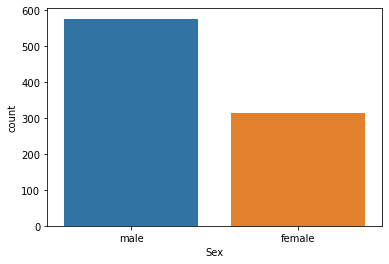

In [16]:
sns.countplot(x='Sex',data=data)

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

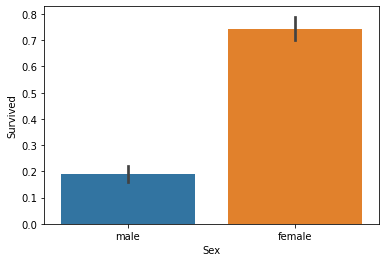

In [17]:
sns.barplot(x="Sex", y ="Survived", data=data)

Se observa que hay alguna relación entre la variable clase y la variable `Sex`, ya que sobreviven muchos más pasajeros que son mujeres frente a los hombres.

### Age

Indica la edad del pasajero y es una variable numérica.

C:\Users\angel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

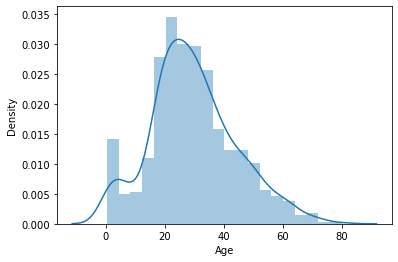

In [18]:
sns.distplot(data['Age'])

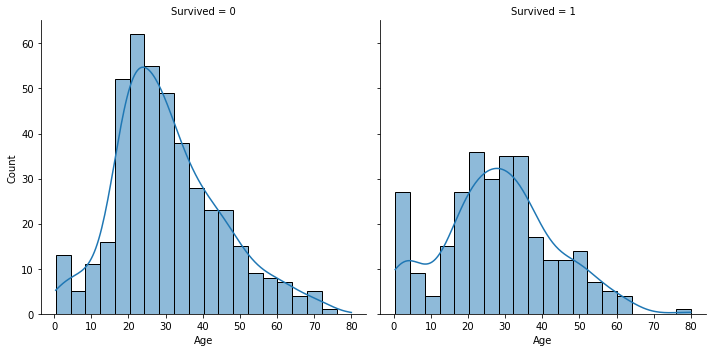

In [19]:
sns.displot(data=data, x='Age', col='Survived', kde=True)

Aparentemente no hay ninguna relación entre la variable clase y la edad de los pasajeros, ya que ambas gráficas siguen un distribución normal de manera similar. Por lo que parece que esta variable por si sola no aporta información.

### SibSp

La variable indica la cantidad de hermanos/esposos que había a bordo del barco.

<AxesSubplot:xlabel='SibSp', ylabel='count'>

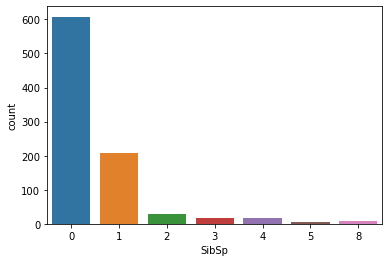

In [20]:
sns.countplot(x='SibSp',data=data)

Podemos observar que la mayoría de pasajeros tenían 0 o 1 hermano/esposo. No habiendo casi pasajeros con más de 1. Además se ha detectado la presencia de outliers tal y como vimos anteriormente.

<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

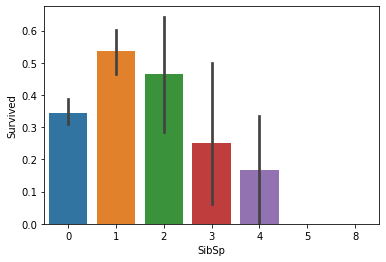

In [21]:
sns.barplot(x="SibSp", y ="Survived", data=data)

Aunque para esta variable hay que tener cuidado con los outlier, parece que hay alguna relación con la variable clase, ya que los pasajeros que tenían algún hermano/esposo a bordo sobrevivieron más.

### Parch

Indica la cantidad de padres / hijos que había a bordo del barco.

<AxesSubplot:xlabel='Parch', ylabel='count'>

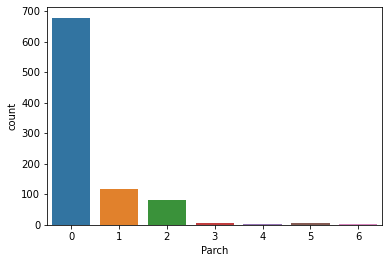

In [22]:
sns.countplot(x='Parch',data=data)

La mayoría de pasajeros no tenían ningún padre / hijo a bordo. No habiendo casi casos con 1 o más (outliers).

<AxesSubplot:xlabel='Parch', ylabel='Survived'>

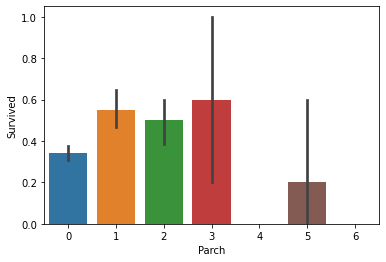

In [23]:
sns.barplot(x="Parch", y ="Survived", data=data)

A simple vista parece que esta variable tiene relación con la variable clase debido a que los pasajeros con padres o hijos a bordo sobrevivieron más que los que no tenían ni padres ni hijos a bordo.

Esta variable se puede combinar (mediante suma) con la variable `SibSp` que indica la cantidad de hermanos/esposos que hay a bordo y obtener una variable que indique la cantidad de familiares que tenían los pasajeros a bordo.

### Fare

Es un valor numérico con el precio del ticket.

C:\Users\angel\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Fare', ylabel='Density'>

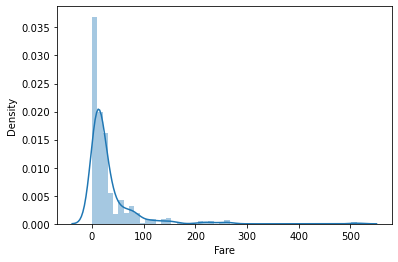

In [24]:
sns.distplot(data['Fare'])

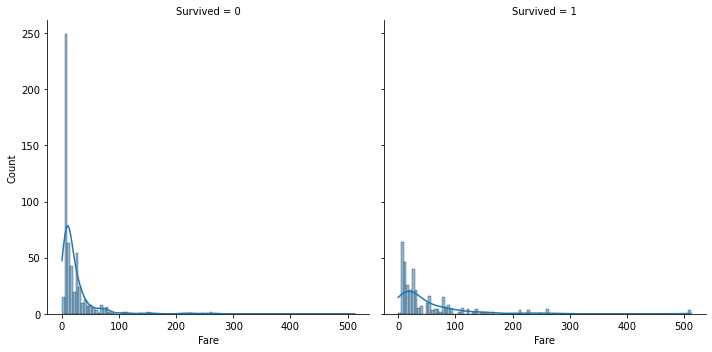

In [25]:
sns.displot(data=data, x='Fare', col='Survived', kde=True)

Al igual que con la variable `Age`, parece que la variable `Fare` no aporta información por si sola, ya que las dos gráficas anteriores siguen una distribución normal. Además, hay que tener cuidado con los outliers que tiene esta variable.

### Ticket

Almacena el número del ticket. Si observamos la cantidad de valores que puede tomar esta variable, vemos la mayoría son únicos. Además no parece que se pueda extraer algún patrón ni generar otra variable a partir de esta. Por lo que parece que esta variable es irrelevante para el problema.

In [26]:
data['Ticket'].sample(20, random_state=seed)

PassengerId
710                2661
440          C.A. 18723
841    SOTON/O2 3101287
721              248727
40                 2651
291               19877
301                9234
334              345764
209              367231
137               11752
138              113803
697              363592
486                4133
245                2694
345              229236
854            PC 17592
622               11753
654              330919
887              211536
111              110465
Name: Ticket, dtype: object

In [27]:
data['Ticket'].value_counts() # mayoria de los valores son unicos

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

### Cabin

Indica la categoría de la cabina. La mayoría de valores para esta variable son únicos, aunque a lo mejor se podría generar una nueva característica a partir de esta cogiendo solo la primera letra de la cabina. 

Aunque en este caso no se utilizará esta variable y se eliminará directamente porque la mayoría de sus valores son nulos.

In [28]:
data['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

### Embarked

Indica el puerto desde el que se embarcó (C, Q o S). La mayoría de los pasajeros embarcó en el puerto S.

<AxesSubplot:xlabel='Embarked', ylabel='count'>

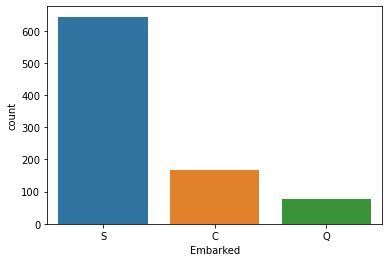

In [29]:
sns.countplot(x='Embarked',data=data)

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

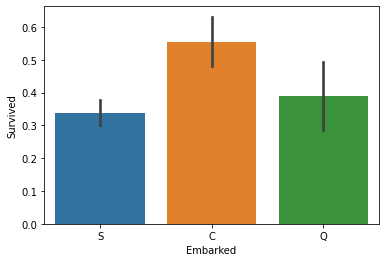

In [30]:
sns.barplot(x="Embarked", y ="Survived", data=data)

Podemos observar que hay relación entre esta variable y la variable clase. Según se observa los pasajeros que embarcaron en el puerto C sobrevivieron mas que los que embarcaron en los puertos S o Q.

## 3.2. Construcción de nuevas características

### Título

Como se vio en el análisis univariado la variable `Name` por si sola no aporta información ya que contiene valores únicos, pero se observó que todos los nombres incluyen un título para cada persona. Se va a construir una nueva característica con dicho título con la esperanza de que pueda aportar algo de información al problema.

In [31]:
data['Title'] = data['Name'].str.split(', ').str[1].str.split('.').str[0]
data.sample(5, random_state=seed)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C,Master
440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S,Mr
841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S,Mr
721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.0000,NaN,S,Miss
40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,NaN,C,Miss


Vamos a comprobar que valores se han generado.

In [32]:
data['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

Podemos observar que para las categorías `Mr`, `Miss` y `Mrs` hay bastantes ejemplos, pero para el resto no tienen casi instancias por lo que todas las categorías con menos de 50 valores se van a agrupar en una nueva categoría llamada `Other`.

In [33]:
data.loc[(data['Title'] != 'Mr') & (data['Title'] != 'Miss') & (data['Title'] != 'Mrs'), 'Title'] = 'Other'
data.sample(5, random_state=seed)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C,Other
440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S,Mr
841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S,Mr
721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.0000,NaN,S,Miss
40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,NaN,C,Miss


Obtenemos así las siguientes categorías:

<AxesSubplot:xlabel='Title', ylabel='count'>

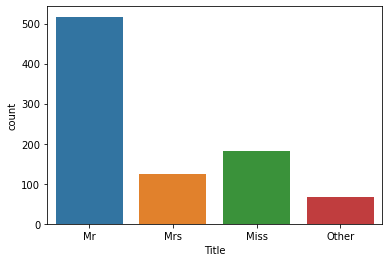

In [34]:
sns.countplot(x='Title',data=data)

<AxesSubplot:xlabel='Title', ylabel='Survived'>

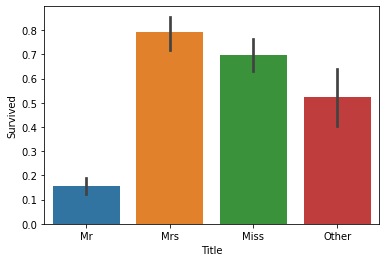

In [35]:
sns.barplot(x="Title", y ="Survived", data=data)

Podemos observar que parece haber relación directa entre esta nueva variable y la variable clase ya que los pasajeros cuyo título es `Mr` sobrevivieron muchísimo menos que el resto.

### Family

Se va a generar una nueva variable que indique la cantidad de familiares de cada pasajero que hay a bordo. Para ello se van a sumar las variables `SibSp` y `Parch` que indican la cantidad de hermanos/esposos y padres/hijos, respectivamente.

In [36]:
data['Family'] = data['SibSp'] + data['Parch']
data.sample(5, random_state=seed)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family
PassengerId,,,,,,,,,,,,,
710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C,Other,2
440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S,Mr,0
841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S,Mr,0
721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.0000,NaN,S,Miss,1
40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,NaN,C,Miss,1


Vamos a comprobar que valores hemos obtenido.

<AxesSubplot:xlabel='Family', ylabel='count'>

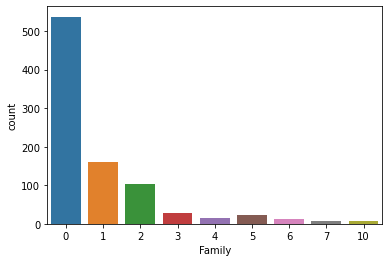

In [37]:
sns.countplot(x='Family',data=data)

Como vemos obtenemos muchos outliers, ya que la mayoría de pasajeros solo cuentan con 0, 1 o 2 familiares a bordo. Para lidiar con estos outliers la solución que vamos a tratar va a ser agrupar todos estos valores en el valor 2, referenciando a `2 o más` familiares a bordo.

In [38]:
data['Family'] = np.minimum(data.Family, 2)

Vamos a generar los gráficos para ver que tal son los datos que hemos obtenido.

<AxesSubplot:xlabel='Family', ylabel='count'>

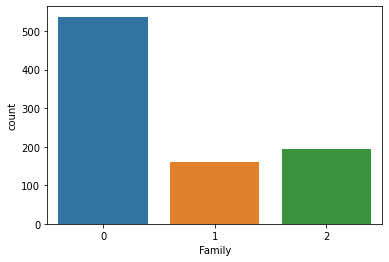

In [39]:
sns.countplot(x='Family',data=data)

<AxesSubplot:xlabel='Family', ylabel='Survived'>

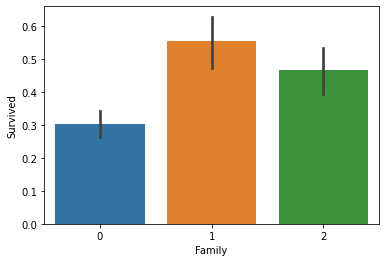

In [40]:
sns.barplot(x="Family", y ="Survived", data=data)

Se observa que hay una relación directa entre esta variable y la variable clase ya que los pasajeros con algún familiar a bordo sobrevivieron más. Por eso se va a generar una variable `Family` que indique si el pasajero tenía algún familiar a bordo (valor `1`) o si estaba solo (valor `0`), ya que no hay casi diferencia entre tener 1 o más a bordo.

## 3.3. Análisis multivariado

Para realizar el análisis multivariado se va a generar una matriz de correlación entre las variables y un pairplot para ver la relación por pares entre las diferentes variables.

***Nota:*** las variables `Name`, `Ticket`, `Cabin`, `Embarked` no se han incluído en estos gráficos al ser variables categóricas cuyos valores no presentan ninguna ordenación. Además, de estas 4 variables la única que parece tener alguna utilidad para el problema es `Embarked`.

Primero voy a realizar una codificación binaria para la variable `Sex` (`0 - male` y `1 - female`).

In [41]:
data["Sex"].replace(['male', 'female'], [0,1], inplace=True)

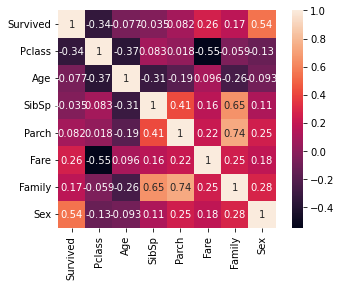

In [42]:
cols = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family', 'Sex']
sns.heatmap(data[cols].corr(), annot = True, square = True)
plt.show()

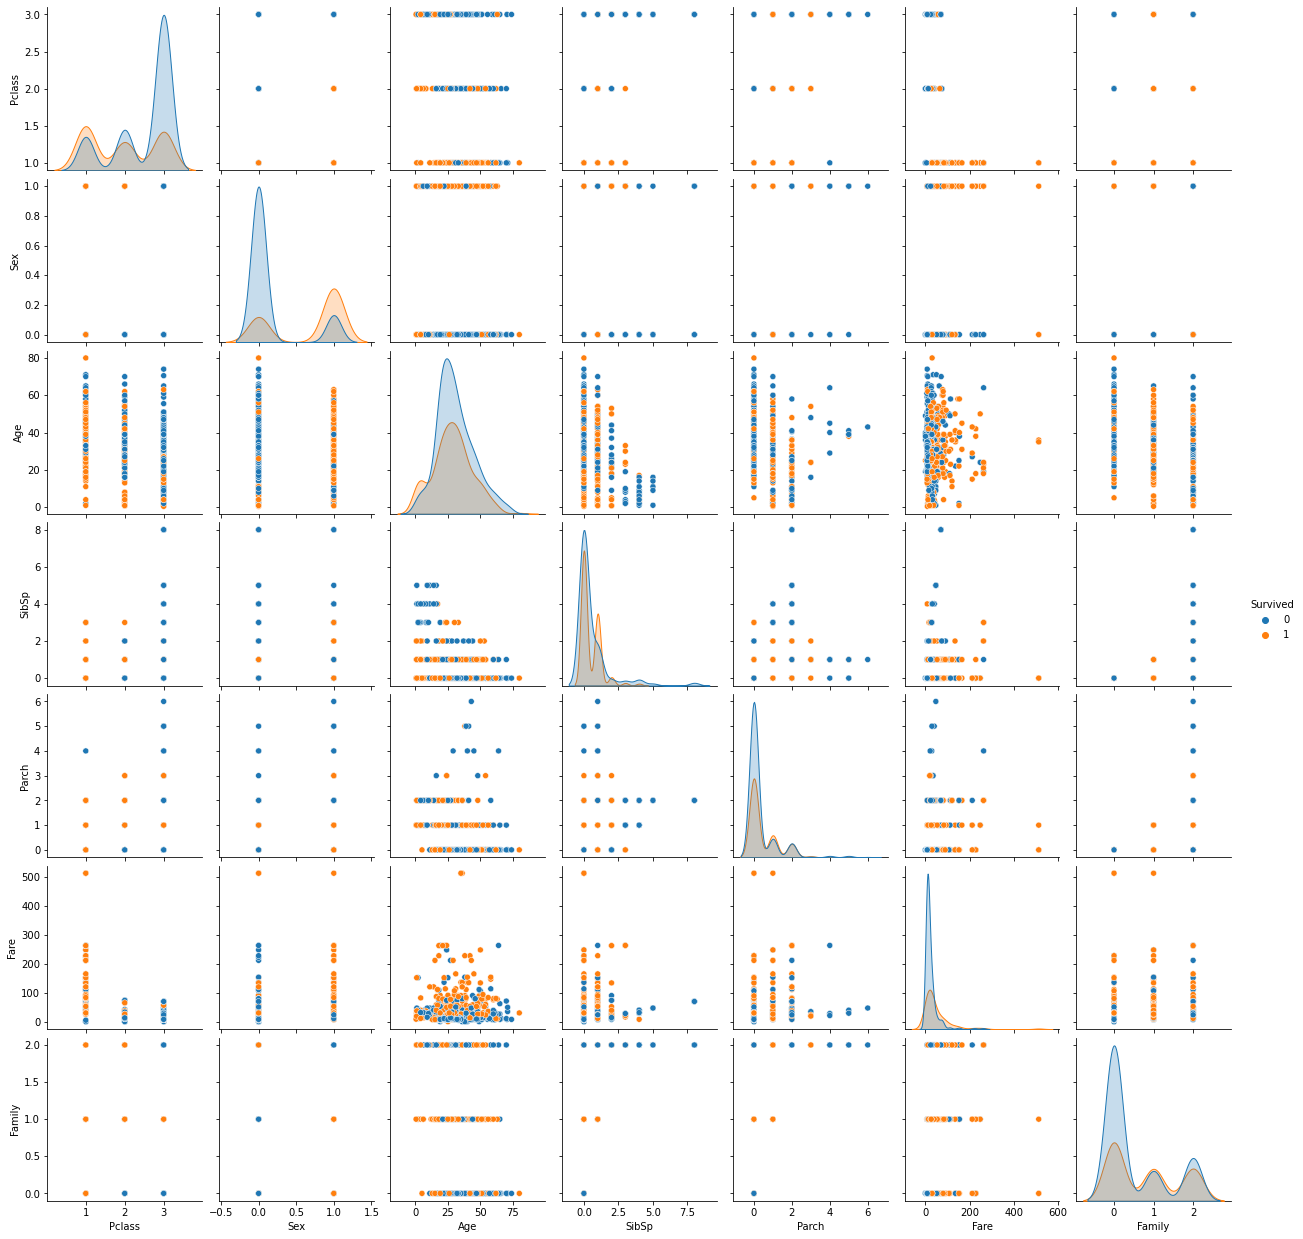

In [43]:
sns.pairplot(data, hue="Survived")

De estas dos gráficas se puede obtener información muy útil al problema.

De la matriz de correlación podemos observar que relación hay entre las distintas variables, y si esta relación es positiva o negativa. En este caso vemos que la variable `Pclass` está muy relacionada con la variable clase, además también tiene relación con las variables `Age` y `Fare`. La variable `Sex` está muy relacionada con la variable clase. Además, la variable `Fare` si que parece relacionarse positivamente con la variable clase, aunque en el análisis univariado parecía no relacionarse mucho.

Del pairplot además de la relación entre las variabes se puede utilizar para buscar un buen punto de corte para discretizar las variables numéricas. En este caso vemos que para las variables `Age` y `Fare` no parece poder aplicarse un buen discretizado.

## 3.4. Concluiones análisis exploratorio

Estas son las conclusiones que se han ido sacando a lo largo del análisis exploratorio:

- ***Survived:*** La variable clase está desbalanceada.
- ***Pclass:*** tiene relación directa con la variable clase.
- ***Name:*** la mayoría de sus valores son únicos y no aporta casi información.
- ***Sex:*** tiene relación directa con la variable clase.
- ***Age:*** individualmente no tiene mucha relación con la variable clase, pero se relaciona con la variable `Pclass`, por lo que puede ser bastante útil. No se ha encontrado ningún punto de corte válido para realizar un discretizado. Cuenta con casi 200 valores nulos. Además dispone de algunos outliers.
- ***SibSp:*** tiene relación directa con la variable clase.
- ***Parch:*** tiene relación directa con la variable clase.
- ***Fare:*** tiene relación directa con la variable clase, además se relaciona con otras variables como la variable `Pclass`. Presenta bastantes outliers. No se ha encontrado ningún punto de corte válido para realizar un discretizado.
- ***Ticket:*** la mayoría de sus valores son únicos y no aporta casi información.
- ***Cabin:*** la mayoría de sus valores son nulos.
- ***Embarked:*** tiene relación directa con la variable clase. Además tiene 2 valores nulos.
- ***Title:*** se ha generado a partir de `Name` y parece tener cierta uitlidad.
- ***Family:*** se ha generado a partir de `SibSp` y `Parch` y parece tener cierta uitlidad.
- El problema cuenta con varias características categóricas que serán necesario codificar.

# 4. Preprocesamiento de datos

Después de terminar el análisis exploratorio de datos, vamos a intentar preparar los datos a partir de las conclusiones que hemos obtenido para obtener un mejor rendimiento al entrenar los modelos.

Para realizar todas las transformaciones necesarias sobre los datos se va a utilizar el concepto de `pipeline`. En un pipeline se definen todas las transformaciones que queremos aplicar sobre los datos y el pipeline se encarga de realizarlas todas, tanto para los datos de entrenamiento como para los de prueba. Además, con el uso de un pipeline nos aseguramos de no cometer `fuga de datos`, es decir, no se introducirá información del conjunto de prueba en los datos utilizados para entrenar a los modelos.

## Construcción de nuevas características

Crearemos unos `custom transformers` para generar las dos nuevas características `Title` y `Family`.
* Para la variable `Title` se extraerá el título de la columna `Name` y se dejarán los valores `Mr`, `Miss` y `Mrs`. Para el resto de casos se asignará el valor `Other`.
* Para la variable `Family` se sumarán las columnas `SibSp` y `Parch`. Al resultado se le aplicará el mínimo con el valor 1, para que no tenga un valor superior a este, obteniendo así 0 para los pasajeros que no tenían familiares a bordo y 1 para aquellos que si tenían.

In [44]:
class TitleTransformer(BaseEstimator, TransformerMixin): 
 
    def fit(self, X, y = None):
        return self
    
    def transform( self, X, y = None ):
        X['Title'] = X['Name'].str.split(', ').str[1].str.split('.').str[0]
        X.loc[(X['Title'] != 'Mr') & (X['Title'] != 'Miss') & (X['Title'] != 'Mrs'), 'Title'] = 'Other'
        return X
    
#title_transformer = TitleTransformer()

In [45]:
class SumColumnsMax(BaseEstimator, TransformerMixin): 
    def __init__(self, op1, op2, result, max_value):
        self.op1 = op1
        self.op2 = op2
        self.result = result
        self.max_value = max_value
    
    def fit(self, X, y = None):
        return self
    
    def transform( self, X, y = None ):
        X[self.result] = np.minimum(X[self.op1] + X[self.op2], self.max_value)
        return X
    
#sum_columns = SumColumnsMax('SibSp', 'Parch', 'Family', 1)

## Eliminar columnas

Crearemos otro `custom transform` que se encargará de eliminar las columnas indicadas, para eliminar las columnas que hemos detectado que no aportan información útil.

In [46]:
class ColumnsDropper(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)
    
#column_dropper = ColumnsDropper(['Ticket', 'Name', 'SibSp', 'Parch', 'Cabin'])

## Valores nulos

Para el tratamiento de valores nulos se realizará una imputación: 
* Para las variables categóricas se asignará el valor más frecuente.
* Para las variables numéricas se aplicará un knn. Ya que como vimos en el análisis exploratorio las características `Age` y `Fare` se relacionaban con el resto de características.

In [47]:
# categorical
most_frequency_imputer = SimpleImputer(strategy='most_frequent')

# numerical
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

## Outliers

Para el tratamiento de outliers crearemos un `custom transformer` que les asignará a todos los outliers un valor máximo como límite.

In [48]:
class LimitOutlier(BaseEstimator, TransformerMixin): 
    
    def fit(self, X, y = None):
        self.limits = []
        for col in range(X.shape[1]):
            Q1 = np.nanpercentile(X[col], 25)
            Q3 = np.nanpercentile(X[col], 75)
            IQR = Q3 - Q1
            min_quartile = Q1 - 1.5*IQR
            max_quartile = Q3 + 1.5*IQR
            
            self.limits.append(max_quartile)
        
        return self
    
    def transform( self, X, y = None ):
        check_is_fitted(self, ['limits'])
        X2 = X.copy()
        for col in range(len(self.limits)):
            X2[col] = np.minimum(X[col], self.limits[col])
        return X2
    
#limit_outlier = LimitOutlier()

## Encoding

Para las variables categóricas se codificarán mediante un `one hot encoding`.

In [49]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

## Construcción del pipeline

Ahora que se han definido todos los pasos de preprocesamiento se va a construir el `pipeline`. El `pipeline` realizará las siguientes operaciones en este orden:

![Pipeline](pipeline.png "Pipeline")

In [50]:
numerical_cols = ['Age', 'Fare']
categorical_cols = ['Pclass', 'Sex', 'Embarked', 'Title']
drop_col = ['Ticket', 'Name', 'SibSp', 'Parch', 'Cabin']

In [51]:
numerical_transformer = Pipeline(steps=[('imputer', knn_imputer),
                                  ('outlier', LimitOutlier())])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                  ('encoder', OneHotEncoder(handle_unknown='ignore'))])

column_transformer = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ], remainder='passthrough')


preprocessor = Pipeline(steps=[('family', SumColumnsMax('SibSp', 'Parch', 'Family', 1)),
                               ('title', TitleTransformer()),
                               ('drop', ColumnsDropper(drop_col)),
                               ('columtransform', column_transformer)])

# 5. Entrenamiento de los modelos

Ahora que hemos definido un `pipeline` que contiene todo el preprocesamiento que queremos realizar sobre nuestros datos vamos a entrenar varios modelos a partir de estos datos preprocesados.

Un aspecto fundamental para obtener buenos resultados con algoritmos de aprendizaje es elegir los parámetros adecuados. En este caso se ha utilizado al objeto `GridSearchCV` que realiza una `validación cruzada` para elegir los parámetros que obtienen mejores resultados a partir de una lista de parámetros dada.

Después de obtener los mejores parámetros para cada modelo se realizará un emsemble con los mejores modelos obtenidos.

Para empezar cargaremos los datos que disponemos para validar y entrenar los modelos:

In [52]:
data = pd.read_csv(filepath, index_col=index)
X = data.drop(columns=['Survived'])
y = data['Survived']

Ahora dividiremos este conjunto de datos en dos:
- Conjunto de datos de entrenamiento: datos que se usarán para seleccionar la mejor configuración de parámetros para los modelos y entrenarlos con esa configuración.
- Conjunto de datos de validación: datos que se usarán después de entrenar los modelos con la mejor configuración de parámetros para evaluar su rendimiento.

***Importante:*** al tener un conjunto de datos desbalanceado se realiza una partición de datos estratificada para mantener el mismo porcentaje de valores positivos (1) y negativos (0) de la variable clase.

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.18, random_state=seed)

Definimos una función que recibe un modelo, la configuración de parámetros que queremos validar y los datos para entrenar ese modelo. Esta función realizará una validación cruzada con 5 fold para elegir la mejor configuración de parámetros y posteriormente utilizará el conjunto de datos de entrenamiento completo para entrenar al modelo con la mejor configuración de parámetros.

In [54]:
def fitCV(model, parameters, X, y, preprocessor=preprocessor):

    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)])
    
    parameters['preprocessor__columtransform__num__imputer__n_neighbors'] = [5, 10]
    parameters['preprocessor__columtransform__num__imputer__weights'] = ['uniform', 'distance']
    
    GS = GridSearchCV(my_pipeline, param_grid=parameters, cv=5, scoring='accuracy', refit=True, verbose=-1)
    GS.fit(X, y)
    
    print("Mejor score para la mejor configuracion de parametros: ", GS.best_score_)
    print("Mejor configuración de parámetros: ", GS.best_params_)
    
    return GS.best_estimator_

Ahora vamos a entrenar los siguientes algoritmos utilizando esta función:
- Support Vector Machine
- Knn
- Regresión logística
- Naive Bayes
- Árboles de decisión
- Ada Boost
- Bagging
- Random Forest
- Gradient Boosting
- Histogram Gradient Boosting

## SVM

In [55]:
model = SVC(random_state=seed)

parameters = {}
parameters['model__C'] = [0.75, 0.85, 0.95, 1]

svm = fitCV(model, parameters, X_train, y_train)

Mejor score para la mejor configuracion de parametros:  0.7
Mejor configuración de parámetros:  {'model__C': 0.85, 'preprocessor__columtransform__num__imputer__n_neighbors': 5, 'preprocessor__columtransform__num__imputer__weights': 'uniform'}


## KNN

In [56]:
model = KNeighborsClassifier(n_neighbors = 5)

parameters = {}
parameters['model__weights'] = ['uniform', 'distance']
parameters['model__n_neighbors'] = [1, 2, 3, 5, 7, 10]

knn = fitCV(model, parameters, X_train, y_train)

Mejor score para la mejor configuracion de parametros:  0.7356164383561643
Mejor configuración de parámetros:  {'model__n_neighbors': 7, 'model__weights': 'distance', 'preprocessor__columtransform__num__imputer__n_neighbors': 5, 'preprocessor__columtransform__num__imputer__weights': 'uniform'}


## Regresion logistica

In [57]:
model = LogisticRegression(solver='liblinear', random_state=seed)

parameters = {}
parameters['model__penalty'] = ['l1', 'l2']
parameters['model__C'] = [0.75, 0.85, 0.95, 1]
parameters['model__class_weight'] = [None, 'balanced']

logistic_regression = fitCV(model, parameters, X_train, y_train)

Mejor score para la mejor configuracion de parametros:  0.8219178082191781
Mejor configuración de parámetros:  {'model__C': 1, 'model__class_weight': None, 'model__penalty': 'l2', 'preprocessor__columtransform__num__imputer__n_neighbors': 10, 'preprocessor__columtransform__num__imputer__weights': 'uniform'}


## Naive bayes

In [58]:
model= GaussianNB()

parameters = {}
parameters['model__var_smoothing'] = [1e-9, 1e-8, 1e-5, 1e-1]

nb = fitCV(model, parameters, X_train, y_train)

Mejor score para la mejor configuracion de parametros:  0.7931506849315069
Mejor configuración de parámetros:  {'model__var_smoothing': 1e-09, 'preprocessor__columtransform__num__imputer__n_neighbors': 5, 'preprocessor__columtransform__num__imputer__weights': 'uniform'}


## Árboles de decisión

In [59]:
model = DecisionTreeClassifier(random_state=seed)

parameters = {}
parameters['model__criterion'] = ['gini', 'entropy']
parameters['model__ccp_alpha'] = [0.0, 0.1, 0.2]
parameters['model__max_depth'] = [3, 5, 6]

decision_tree = fitCV(model, parameters, X_train, y_train)

Mejor score para la mejor configuracion de parametros:  0.8287671232876713
Mejor configuración de parámetros:  {'model__ccp_alpha': 0.0, 'model__criterion': 'gini', 'model__max_depth': 3, 'preprocessor__columtransform__num__imputer__n_neighbors': 10, 'preprocessor__columtransform__num__imputer__weights': 'distance'}


## Ada boost

In [60]:
model = AdaBoostClassifier(random_state=seed)

base_estimator = DecisionTreeClassifier(random_state=seed)
parameters = {}
parameters['model__base_estimator'] = [base_estimator]
parameters['model__n_estimators'] = [50, 100]
parameters['model__learning_rate'] = [0.95, 1.0]
parameters['model__base_estimator__max_depth'] = [1, 2]
parameters['model__base_estimator__criterion'] = ['gini', 'entropy']


ada = fitCV(model, parameters, X_train, y_train)

Mejor score para la mejor configuracion de parametros:  0.8287671232876713
Mejor configuración de parámetros:  {'model__base_estimator': DecisionTreeClassifier(max_depth=1, random_state=42), 'model__base_estimator__criterion': 'gini', 'model__base_estimator__max_depth': 1, 'model__learning_rate': 1.0, 'model__n_estimators': 50, 'preprocessor__columtransform__num__imputer__n_neighbors': 5, 'preprocessor__columtransform__num__imputer__weights': 'uniform'}


## Bagging

In [61]:
model = BaggingClassifier(random_state=seed)

base_estimator = DecisionTreeClassifier(random_state=seed)
parameters = {}
parameters['model__base_estimator'] = [base_estimator]
parameters['model__n_estimators'] = [50, 100]

parameters['model__base_estimator__max_depth'] = [1, 4, 10]
parameters['model__base_estimator__criterion'] = ['gini', 'entropy']

bagging = fitCV(model, parameters, X_train, y_train)

Mejor score para la mejor configuracion de parametros:  0.8438356164383561
Mejor configuración de parámetros:  {'model__base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42), 'model__base_estimator__criterion': 'entropy', 'model__base_estimator__max_depth': 10, 'model__n_estimators': 100, 'preprocessor__columtransform__num__imputer__n_neighbors': 5, 'preprocessor__columtransform__num__imputer__weights': 'uniform'}


## Random Forest

In [62]:
model = RandomForestClassifier(random_state=seed)

parameters = {}
parameters['model__n_estimators'] = [50, 100]
parameters['model__max_features'] = ['sqrt', 'log2']
parameters['model__min_samples_split'] = [5, 10]
parameters['model__criterion'] = ['gini', 'entropy']

random_forest = fitCV(model, parameters, X_train, y_train)

Mejor score para la mejor configuracion de parametros:  0.841095890410959
Mejor configuración de parámetros:  {'model__criterion': 'entropy', 'model__max_features': 'sqrt', 'model__min_samples_split': 10, 'model__n_estimators': 50, 'preprocessor__columtransform__num__imputer__n_neighbors': 10, 'preprocessor__columtransform__num__imputer__weights': 'uniform'}


## Gradient Boosting

In [63]:
model= GradientBoostingClassifier()

parameters = {}
parameters['model__learning_rate'] = [0.01, 0.05, 0.1]
parameters['model__max_depth'] = [1, 2]
parameters['model__criterion'] = ['friedman_mse', 'squared_error']

gradient_boosting = fitCV(model, parameters, X_train, y_train)

Mejor score para la mejor configuracion de parametros:  0.8342465753424657
Mejor configuración de parámetros:  {'model__criterion': 'friedman_mse', 'model__learning_rate': 0.1, 'model__max_depth': 2, 'preprocessor__columtransform__num__imputer__n_neighbors': 5, 'preprocessor__columtransform__num__imputer__weights': 'uniform'}


## Histogram Gradient Boosting

In [64]:
model = HistGradientBoostingClassifier(random_state=seed)

parameters = {}
parameters['model__learning_rate'] = [0.01, 0.05, 0.1]
parameters['model__max_leaf_nodes'] = [5, 10, 15, 31]

hist_gradient_boosting = fitCV(model, parameters, X_train, y_train)

Mejor score para la mejor configuracion de parametros:  0.8479452054794521
Mejor configuración de parámetros:  {'model__learning_rate': 0.05, 'model__max_leaf_nodes': 31, 'preprocessor__columtransform__num__imputer__n_neighbors': 10, 'preprocessor__columtransform__num__imputer__weights': 'uniform'}


# 6. Validación y modelo final

Ahora vamos a evaluar los modelos obtenidos utilizando el conjunto de datos de validación. Para ello vamos a visualizar el `accuracy` obtenido para los datos de entrenamiento y de validación.

In [65]:
models = [('SVM', svm), ('KNN', knn),('logistic_regression', logistic_regression), ('naive_bayes', nb), ('decision_tree', decision_tree),
    ('ada_boost', ada), ('bagging', bagging), ('random_forest', random_forest), ('gradient_boosting', gradient_boosting), ('histogram_gradient_boosting', hist_gradient_boosting)]

In [66]:
print('Accuracy:')
for (name, m) in models:
    print(name)
    print('\tTrain score: ', m.score(X_train, y_train))
    print('\tValidation score: ', m.score(X_val, y_val))

Accuracy:
SVM
	Train score:  0.7
	Validation score:  0.6024844720496895
KNN
	Train score:  0.9849315068493151
	Validation score:  0.7018633540372671
logistic_regression
	Train score:  0.8191780821917808
	Validation score:  0.7888198757763976
naive_bayes
	Train score:  0.7931506849315069
	Validation score:  0.7515527950310559
decision_tree
	Train score:  0.8356164383561644
	Validation score:  0.8012422360248447
ada_boost
	Train score:  0.8602739726027397
	Validation score:  0.7577639751552795
bagging
	Train score:  0.9561643835616438
	Validation score:  0.8322981366459627
random_forest
	Train score:  0.8835616438356164
	Validation score:  0.8136645962732919
gradient_boosting
	Train score:  0.8616438356164383
	Validation score:  0.7701863354037267
histogram_gradient_boosting
	Train score:  0.9191780821917809
	Validation score:  0.8074534161490683


Vemos que los que mejor resultados ofrecen son los ensembles (bagging, random forest, histogram gradient boosting), el árbol de decisión y la regresión logística. Aún así todos cuentan con bastante sobreajuste a los datos de entrenamiento (buenos resultados para los datos de entrenamiento y peores resultados para los datos de validación).

Los dos modelos que menor sobreajuste presentan son los árboles de decisón y la regresión logística. Para este problema disponemos de pocos datos de entrenamiento por lo que los modelos que mejor resultado obtienen son los modelos más simples.

## Modelo final

Ahora se va a construir un modelo final que va a consistir en la unión de los mejores modelos obtenidos, aplicando un voto por la mayoría para predecir la clase que la mayoría de los modelos predigan.

In [67]:
estimators = [('logistic_regression', logistic_regression), ('decision_tree', decision_tree), ('bagging', bagging), 
              ('random_forest', random_forest), ('histogram_gradient_boosting', hist_gradient_boosting)]

voting_classfication = VotingClassifier(estimators =estimators, voting="hard", n_jobs=-1)

Mostramos el `accuracy` obtenido por este modelo final y su matriz de confusión:

In [68]:
voting_classfication.fit(X_train, y_train)

print('Train score: ', voting_classfication.score(X_train, y_train))
print('Val score: ', voting_classfication.score(X_val, y_val))

Train score:  0.8917808219178082
Val score:  0.8198757763975155


In [69]:
def show_results(y, y_pred):
    c_mat = confusion_matrix(y, y_pred)
    sns.heatmap(c_mat, square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()

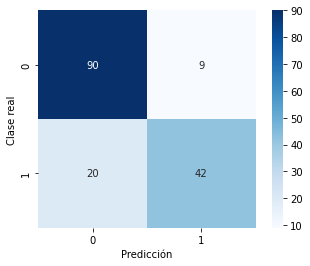

In [70]:
show_results(y_val, voting_classfication.predict(X_val))

Se han obtenido unos buenos resultados con un 82 % para los datos de validación, aún así se ha obtenido algo de sobreajuste ya que para los datos de entrenamiento se ha obtenido casi un 90 %.

Observamos que la mayoría de los fallos se producen para los casos positivos. Aquí se puede observar la influencia de trabajar con un conjunto de datos desbalanceado.

Probablemente si se hubiera trabajado con una métrica de evaluación distinta podríamos haber reducido este problema, aún así como se dijo al principio se ha elegido el `accuracy` porque es la métrica que se utiliza en la competición de kaggle.

# 7. Predicción test

Para acabar con este cuaderno vamos predecir el conjunto de datos de test. Para ello leemos los datos del `.csv`.

In [71]:
filepath = 'test.csv'
test = pd.read_csv(filepath)
test.sample(5, random_state=seed)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
321,1213,3,"Krekorian, Mr. Neshan",male,25.0,0,0,2654,7.2292,F E57,C
324,1216,1,"Kreuchen, Miss. Emilie",female,39.0,0,0,24160,211.3375,NaN,S
388,1280,3,"Canavan, Mr. Patrick",male,21.0,0,0,364858,7.7500,NaN,Q
56,948,3,"Cor, Mr. Bartol",male,35.0,0,0,349230,7.8958,NaN,S
153,1045,3,"Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)",female,36.0,0,2,350405,12.1833,NaN,S


Utilizamos el modelo final para predecir estos datos y construimos un dataframe con el formato requerido en la competición de kaggle.

In [72]:
pred = voting_classfication.predict(test)

In [73]:
survived = pd.Series(pred, name='Survived')
submission = pd.concat([test['PassengerId'], survived], axis=1)

In [74]:
submission.sample(5, random_state=seed)

,PassengerId,Survived
321,1213,0
324,1216,1
388,1280,0
56,948,0
153,1045,1


In [75]:
submission.to_csv('submission.csv', index=False)

Finalmente generamos un archivo `submission.csv` con las predicciones. Con estas predicciones se ha obtenido un `accuracy` de 77.751 % para el conjunto de test en la competición de kaggle.

Podemos observar que es un valor más bajo que el obtenido para los datos de entrenamiento y de validación. Eso es debido a que hemos obtenido sobreajuste en los modelos definidos, pero aún así hemos obtenido unos buenos resultados para un dataset tan pequeño y con tantas particularidades como lo es el de `titanic`.